# Gradio Day!

Gradio is a Python package that creates web interfaces for interacting with various machine learning models. In this project, Gradio interfaces with OpenAI's ChatGPT, Google's Gemini, and Anthropic's Claude to act as chatbots for customer service, tools for creating brochures, and guides for visitor centers. Additionally, it can be used in education, healthcare, creative writing, technical support, language translation, market research, and financial advisory. Today we will build User Interfaces using the outrageously simple Gradio framework.

In [ ]:
# imports

import os
import requests
from bs4 import BeautifulSoup
from typing import List
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic

import gradio as gr

In [ ]:
load_dotenv()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "your_api_key"
google_api_key = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]

os.environ['OPENAI_API_KEY'] = 'your_api_key'
openai_api_key = os.getenv('OPENAI_API_KEY')
openai = OpenAI()

os.environ['ANTHROPIC_API_KEY'] = 'your_api_key'
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

In [5]:
# Connect to OpenAI, Anthropic and Google; 

openai = OpenAI()

claude = anthropic.Anthropic()

google.generativeai.configure()

In [6]:
# A generic system message - no more snarky adversarial AIs!

system_message = "You are a helpful assistant"

In [7]:
# Let's wrap a call to GPT-4o-mini in a simple function

def message_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    completion = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
    )
    return completion.choices[0].message.content

In [12]:
message_gpt("What is the most updated knowledge for you?")

'My knowledge is based on information available up until October 2021. I do not have access to real-time data or events that have occurred beyond that date. If you have specific questions or topics in mind, I can provide information based on what I know up until that time. Please feel free to ask!'

## User Interface time!

In [13]:
view = gr.Interface(
    fn=message_gpt,
    inputs=[gr.Textbox(label="Your message:", lines=6)],
    outputs=[gr.Textbox(label="Response:", lines=8)],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


![Screenshot 2024-12-14 at 12.33.14 PM.png](<attachment:Screenshot 2024-12-14 at 12.33.14 PM.png>)
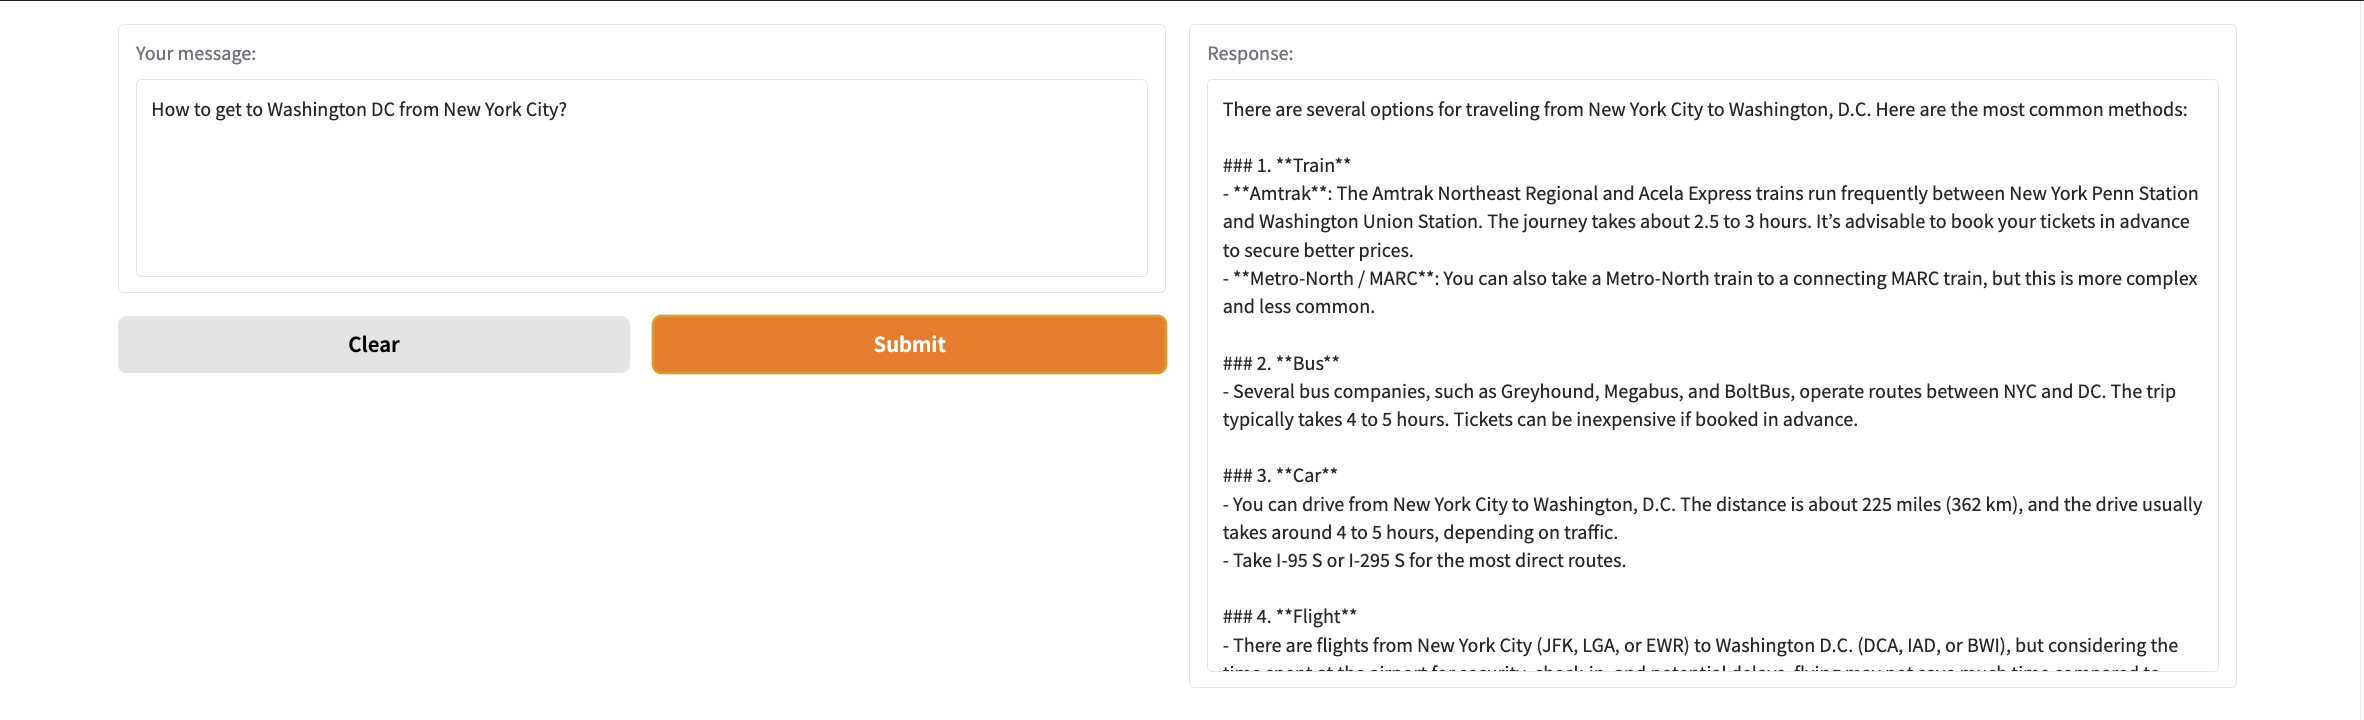

In [15]:
# Let's create a call that streams back results

def stream_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )
    result = ""
    for chunk in stream:
        result += chunk.choices[0].delta.content or ""
        yield result

In [16]:
view = gr.Interface(
    fn=stream_gpt,
    inputs=[gr.Textbox(label="Your message:")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


![Screenshot 2024-12-14 at 12.43.35 PM.png](<attachment:Screenshot 2024-12-14 at 12.43.35 PM.png>)
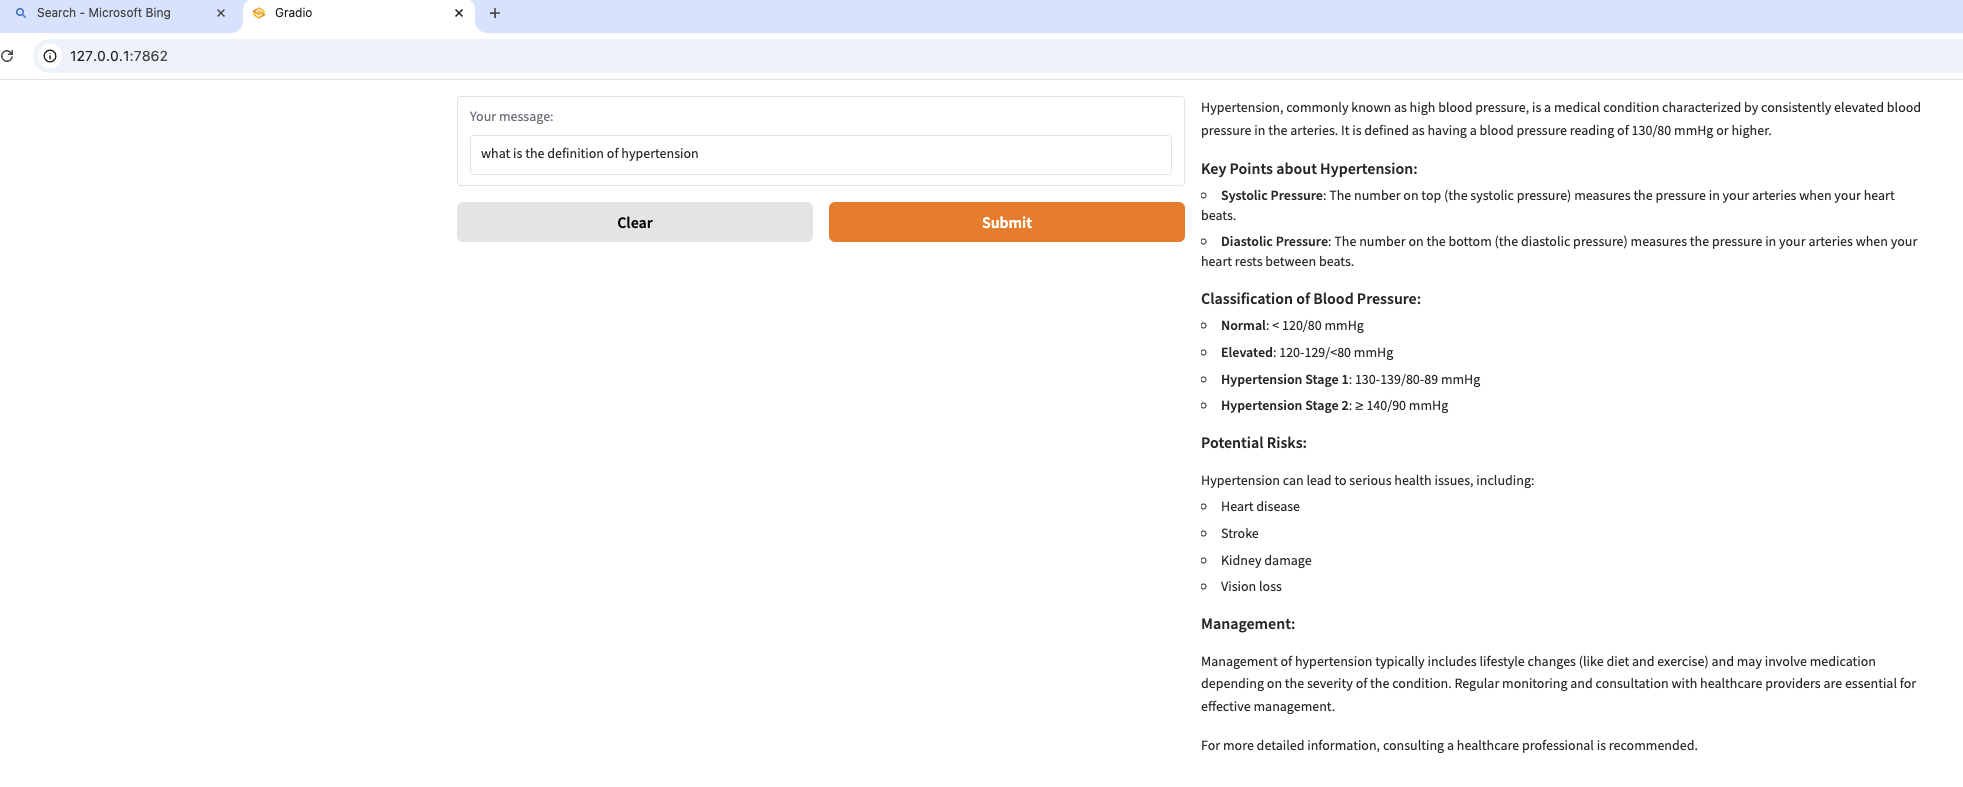

In [17]:
def stream_claude(prompt):
    result = claude.messages.stream(
        model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0.7,
        system=system_message,
        messages=[
            {"role": "user", "content": prompt},
        ],
    )
    response = ""
    with result as stream:
        for text in stream.text_stream:
            response += text or ""
            yield response

In [18]:
view = gr.Interface(
    fn=stream_claude,
    inputs=[gr.Textbox(label="Your message:")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


![Screenshot 2024-12-14 at 12.50.07 PM.png](<attachment:Screenshot 2024-12-14 at 12.50.07 PM.png>)
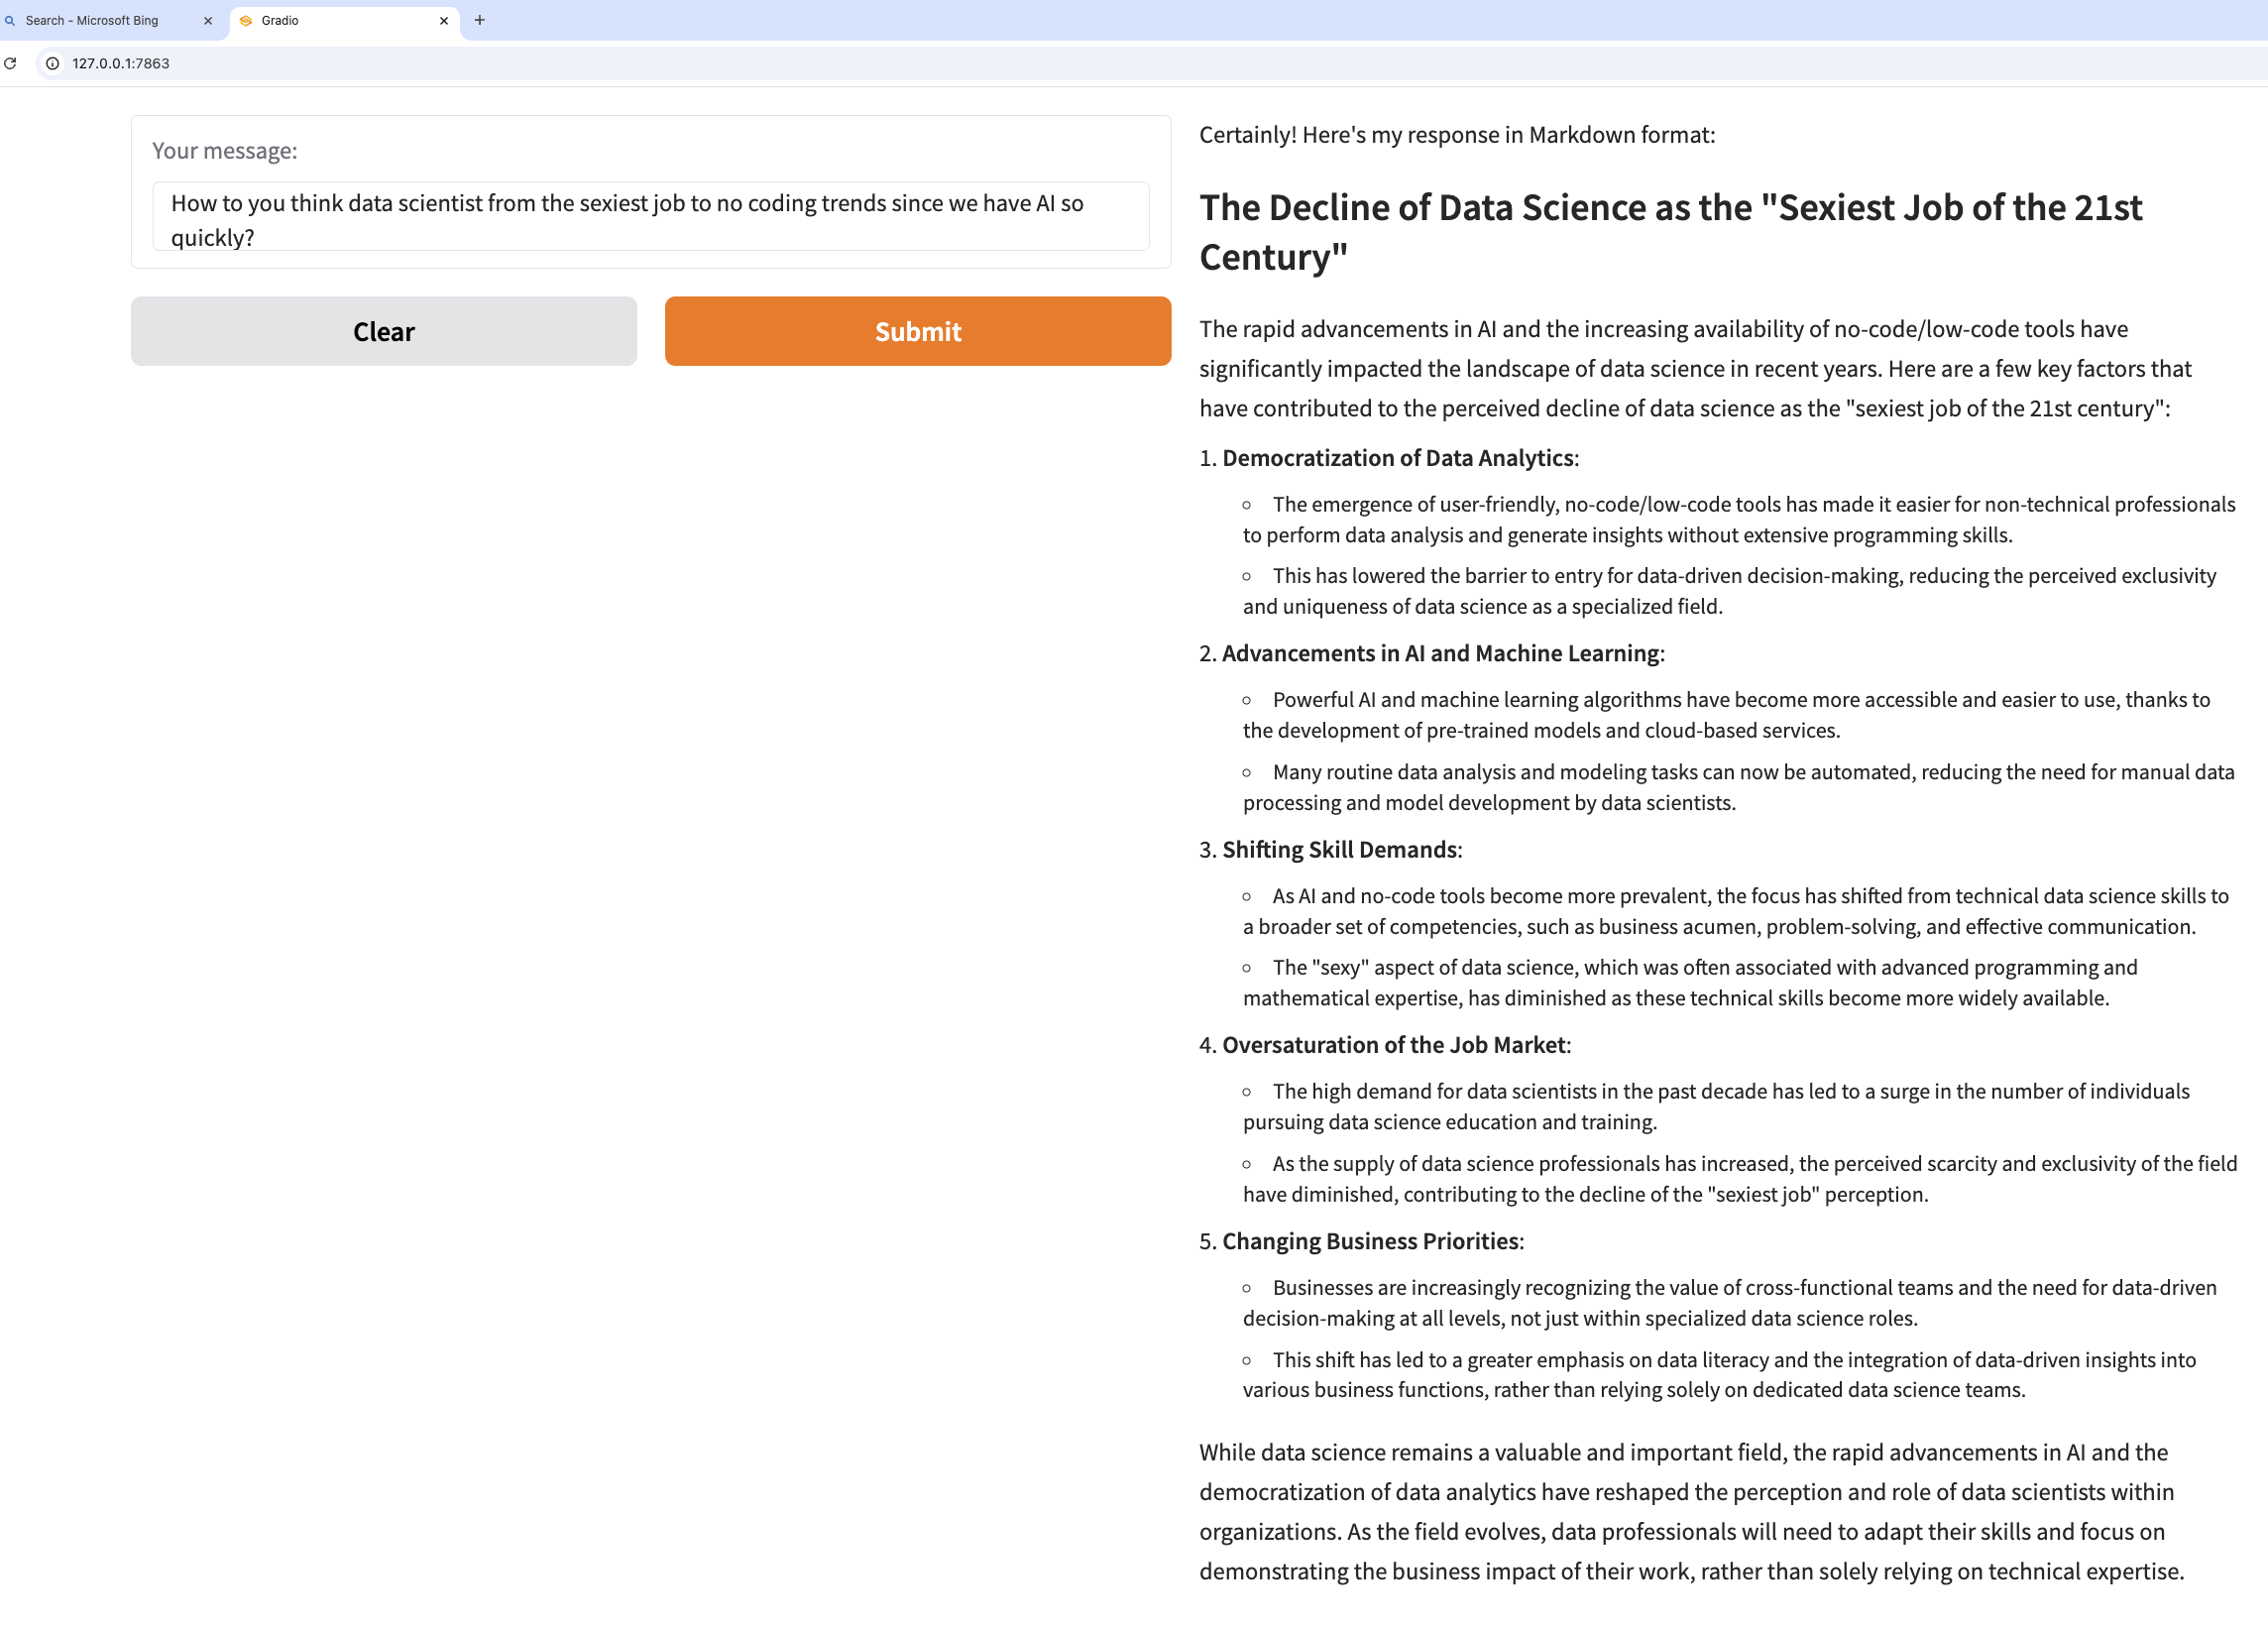

## Minor improvement

I've made a small improvement to this code.

Previously, it had these lines:

```
for chunk in result:
  yield chunk
```

There's actually a more elegant way to achieve this (which Python people might call more 'Pythonic'):

`yield from result`

In [19]:
def stream_model(prompt, model):
    if model=="GPT":
        result = stream_gpt(prompt)
    elif model=="Claude":
        result = stream_claude(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result

In [20]:
view = gr.Interface(
    fn=stream_model,
    inputs=[gr.Textbox(label="Your message:"), gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


![Screenshot 2024-12-14 at 12.54.35 PM.png](<attachment:Screenshot 2024-12-14 at 12.54.35 PM.png>)
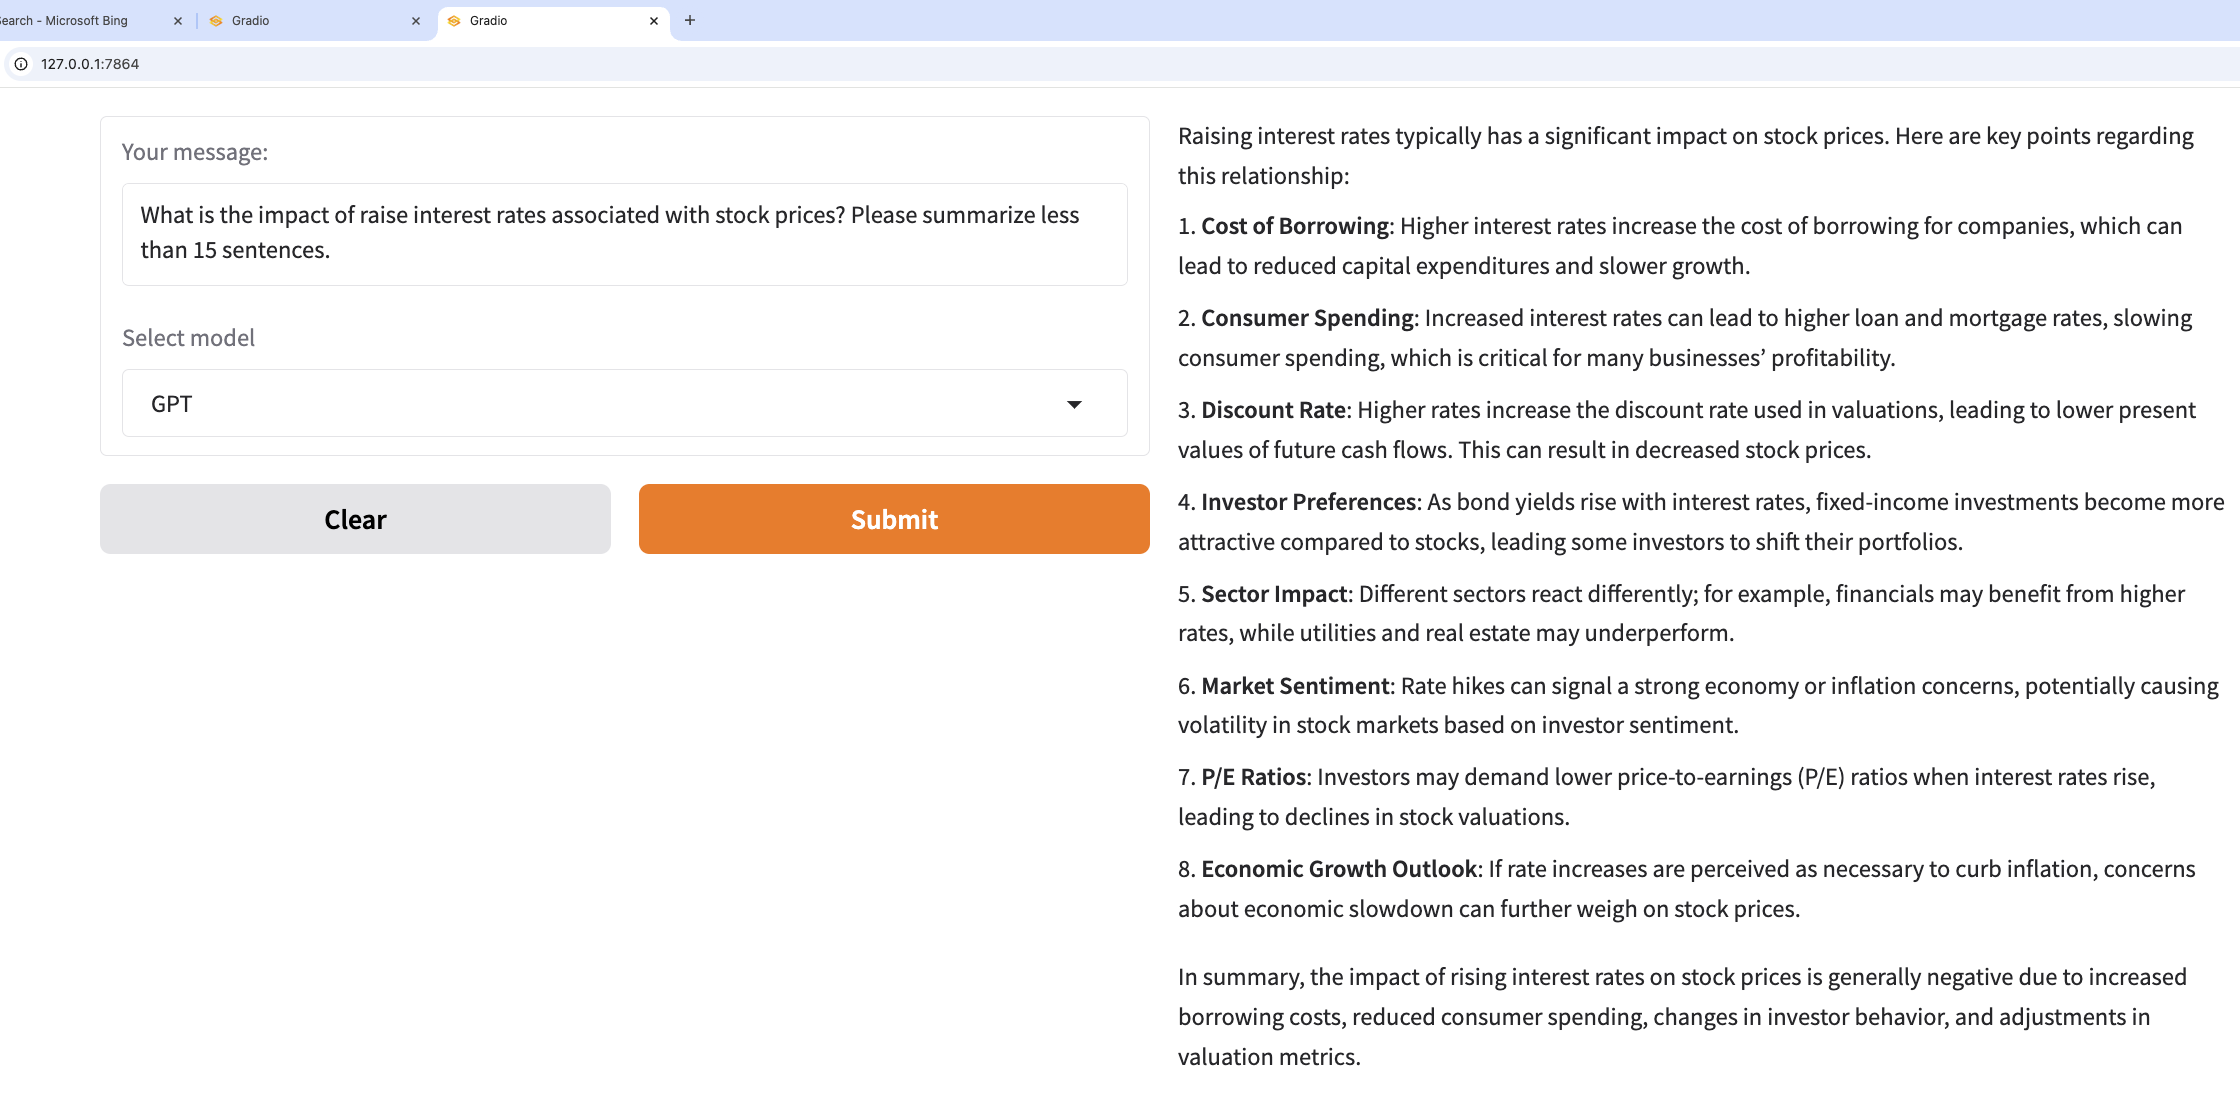

# Building a company brochure generator

Now you know how - it's simple!

In [21]:
# A class to represent a Webpage

class Website:
    url: str
    title: str
    text: str

    def __init__(self, url):
        self.url = url
        response = requests.get(url)
        self.body = response.content
        soup = BeautifulSoup(self.body, 'html.parser')
        self.title = soup.title.string if soup.title else "No title found"
        for irrelevant in soup.body(["script", "style", "img", "input"]):
            irrelevant.decompose()
        self.text = soup.body.get_text(separator="\n", strip=True)

    def get_contents(self):
        return f"Webpage Title:\n{self.title}\nWebpage Contents:\n{self.text}\n\n"

In [22]:
# With massive thanks to Bill G. who noticed that a prior version of this had a bug! Now fixed.

system_message = "You are an assistant that analyzes the contents of a company website landing page \
and creates a short brochure about the company for prospective customers, investors and recruits. Respond in markdown."

In [23]:
def stream_brochure(company_name, url, model):
    prompt = f"Please generate a company brochure for {company_name}. Here is their landing page:\n"
    prompt += Website(url).get_contents()
    if model=="GPT":
        result = stream_gpt(prompt)
    elif model=="Claude":
        result = stream_claude(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result

In [24]:
view = gr.Interface(
    fn=stream_brochure,
    inputs=[
        gr.Textbox(label="Company name:"),
        gr.Textbox(label="Landing page URL including http:// or https://"),
        gr.Dropdown(["GPT", "Claude"], label="Select model")],
    outputs=[gr.Markdown(label="Brochure:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


![Screenshot 2024-12-14 at 12.58.18 PM.png](<attachment:Screenshot 2024-12-14 at 12.58.18 PM.png>)
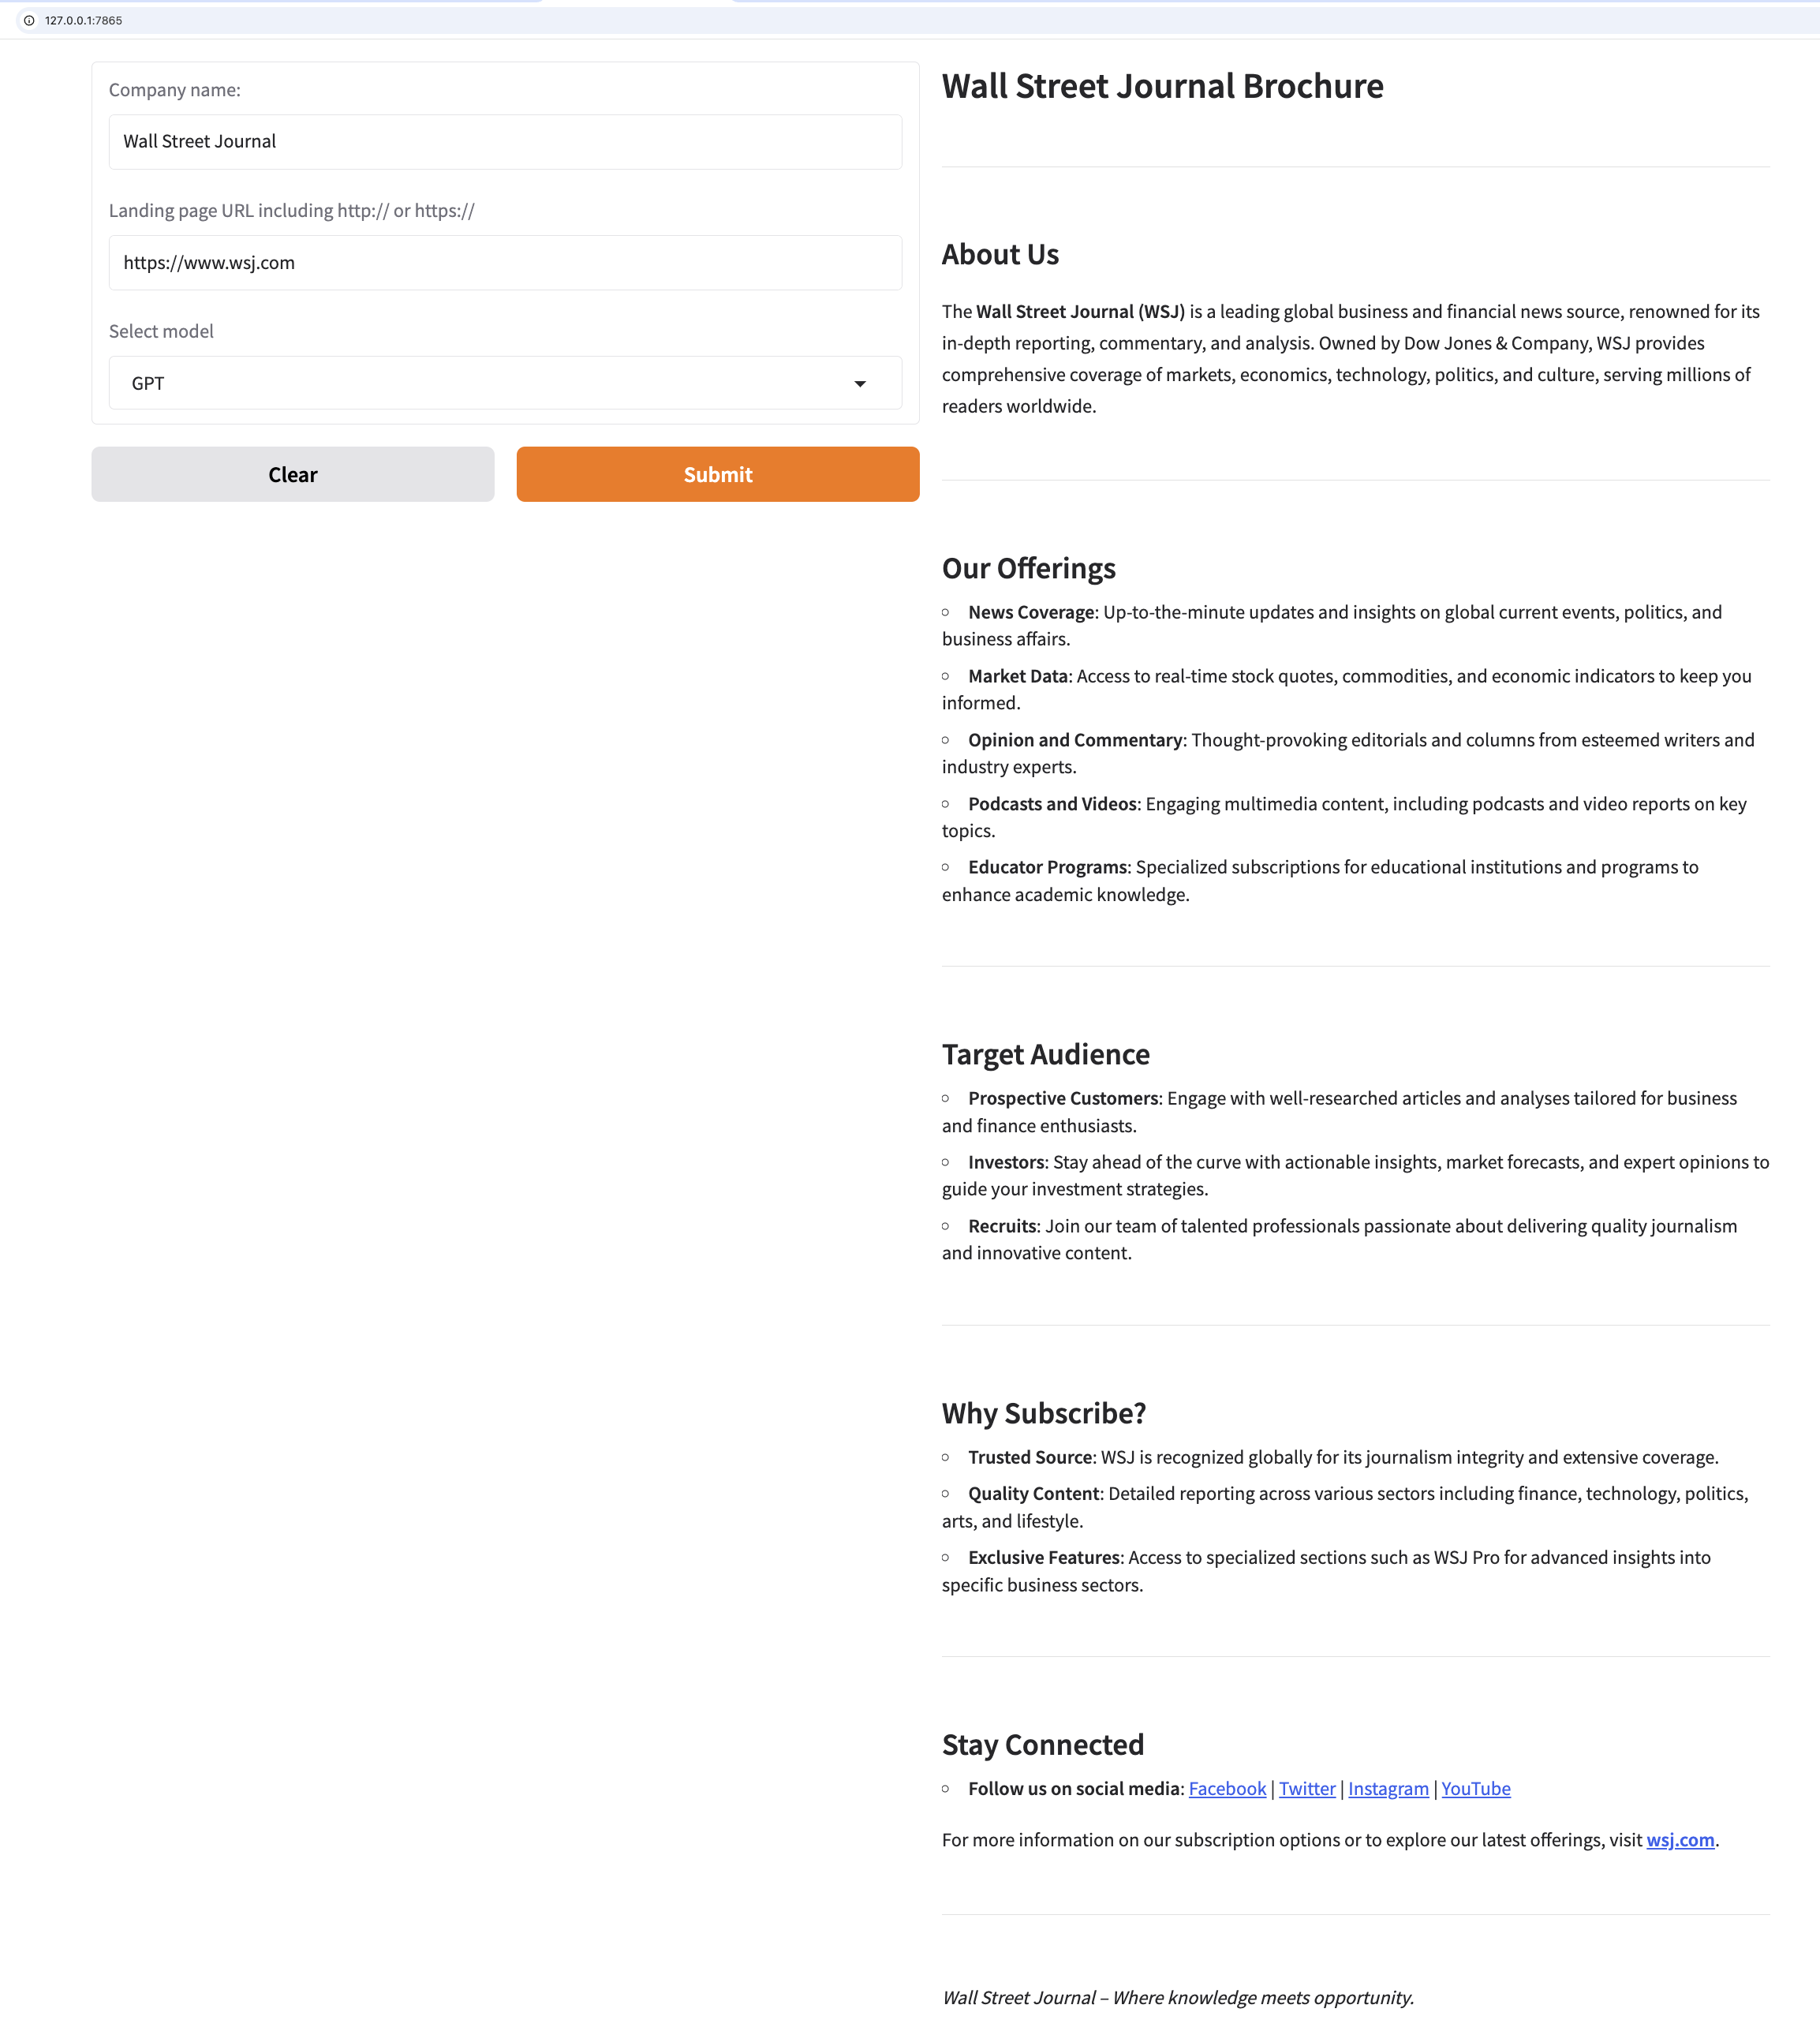